# MCMC and Gibbs Sampling

Bayesian data analysis 的目标是确定一个后验分布：

$p(\theta|X) = \frac{p(X|\theta)p(\theta)}{p(X)} = \frac{p(X|\theta)p(\theta)}{\int p(X|\theta^*)p(\theta^*)d\theta^*}$

其中，
* $p(X|\theta)$ 是 likelihood
* $p(\theta)$ 是 prior
* $p(X)$ 是一个归一化常数，也叫 evidence 或 marginal likelihood。

在计算这个后验概率的时候，比较难的地方在于计算分母这个积分。通常有多种解决方法：
1. 找一个共轭先验$p(\theta)$，使得能够得到 closed form 的后验。
2. 用数值积分（numerical integration）。已经不记得这是啥了。。
3. 用更简单形式的概率分布去贴近真实的后验概率。比如 VAE 中用到的 bariational Bayes 方法。
4. 用 Monte Carlo，如 MCMC 和 Gibbs Sampling

我们以一个抛硬币为例，讲一讲这几个不同的方法（不包括变分）。

## 抛硬币
假如有一个不均匀的硬币，我们抛了 n 次以后发现有 h 次是正面朝上的，如何估计抛一次硬币正面朝上的概率？

我们知道抛硬币是一个二项分布，即似然函数 $p(x|\theta)$ 是一个二项分布（这里为了简单，记抛 n 次观测到 h 次正面朝上这个事件为 x）。我们如何计算后验概率 $p(\theta|x)$ ？

### 解法 1. Analytical Solution 

如果我们找一个二项分布的共轭先验（beta 分布），那么后验分布就有 closed form，也是个 beta 分布。

因此，analytical solution 的通常思路是：
* 选择一个先验分布及其参数（通常是共轭先验），使得后验分布有解析解。先验分布可能 uninformative（扁平一点） 或者 informative（瘦高一点）。
* 后验依赖于先验和观测数据。
    * 当观测数据增加时，最大后验估计接近极大似然估计，因为这个时候先验已经被大量样本吞没了，可以忽略。
    * informative prior 需要更多的样本去修正。也很直观，如果先验本身信息量已经很大，就需要更多的样本来纠正它。
* 当然，需要一个合适的模型（似然函数）去给数据建模，比如这个例子的二项分布。
* 后验分布的 mode 即最大后验估计（MAP），使似然函数取值最大的参数是极大似然估计。

在这个扔硬币的例子中，我们假设参数服从 beta 分布，即 $p(\theta) = beta(a, b)$，那么参数的后验分布也服从 beta 分布，即 $p(\theta|x) = beta(a+h, n-h+b)$。有这种漂亮的解析解就很容易算各种东西了。下面这段代码可以看出来，当样本量变大的时候 MAP 就约等于 MLE。

In [45]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import scipy.stats as st
import scipy

%matplotlib inline
%precision 4
plt.style.use('ggplot')

np.random.seed(1234)

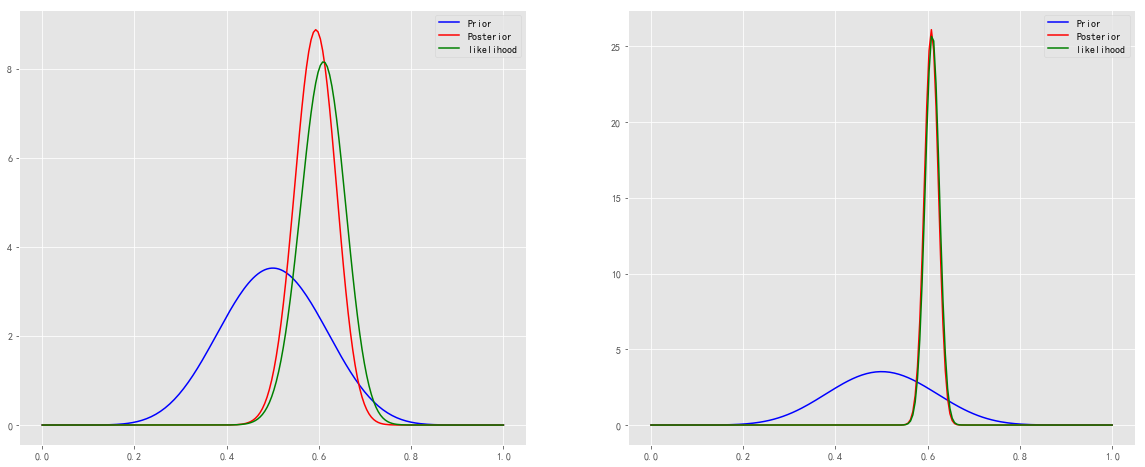

In [98]:
def analytical_solution(n, h, ax):
    a, b = 10, 10
    prior = st.beta(a, b)
    post = st.beta(h+a, n-h+b)

    thetas = np.linspace(0, 1, 200)
    likelihood = st.binom(n, thetas)

    ax.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
    ax.plot(thetas, post.pdf(thetas), label='Posterior', c='red')
    ax.plot(thetas, likelihood.pmf(h) * n, label='likelihood', c='green')
    ax.legend()

f, axis = plt.subplots(1, 2, figsize=(20, 8))
analytical_solution(100, 61, axis[0])
analytical_solution(1000, 610, axis[1])

## 解法 2. Numerical integration
数值积分没研究过，不过最简单的方式是遍历一堆$\theta$的值，来估算P(X)。那么后验概率就可以写为：

$p(\theta|X) = \frac{p(X|\theta)p(\theta)}{\int p(X|\theta^*)p(\theta^*)d\theta^*} \approx \frac{p(X|\theta)p(\theta)}{\sum_{\theta^*}p(X|\theta^*)p(\theta^*)} $

这么做的好处是：我们不需要找一个似然函数的共轭先验，可以找一个任意已经形式的分布，比如高斯分布或混合分布。

这么做的缺点是：参数$\theta$的空间可能非常大，比如参数有 d 维，每一维搜索 n 个数值，则会产生$O(n^d)$个遍历点。

比如，在抛硬币的例子中，我们假设参数的先验服从高斯分布，即$p(\theta)=N(0.5, 0.1)$，这时候后验是没法直接算出解析形式的，就可以用 numerical integration 来求解。从这个例子中可以发现，当我们假设先验服从高斯而不是 beta 分布时，随着样本数量的增加，MAP 同样趋近于 MLE。

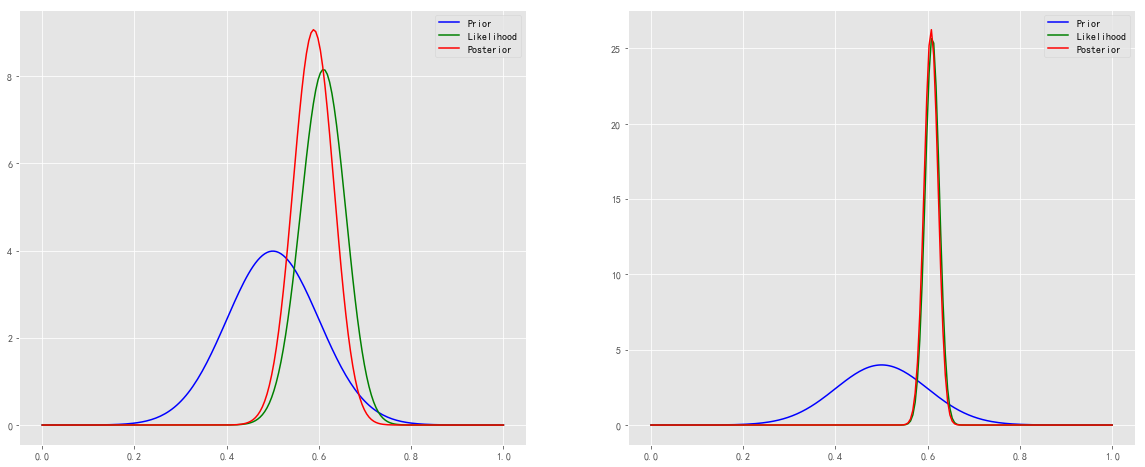

In [3]:
def numerical_integration(n, h, ax):
    thetas = np.linspace(0, 1, 200)
    prior = st.norm(0.5, 0.1)

    post = prior.pdf(thetas) * st.binom(n, thetas).pmf(h)
    post /= (post.sum() / len(thetas))
    
    ax.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
    ax.plot(thetas, n*st.binom(n, thetas).pmf(h), label='Likelihood', c='green')
    ax.plot(thetas, post, label='Posterior', c='red')
    ax.legend()
    
f, axis = plt.subplots(1, 2, figsize=(20, 8))
numerical_integration(100, 61, axis[0])
numerical_integration(1000, 610, axis[1])

## 解法 3. MCMC 采样

对于一个后验分布，如果 marginal likelihood 不好计算，并且参数空间又太大，该怎么求呢？如果我们能从后验分布中采样一些独立的样本点，就可以通过 Monte Carlo integration 来计算这个后验分布（这里其实我不太懂，暂时先不 care 了，把重点放在采样本身吧）。

那么问题就变为，如何这个后验分布中采集独立样本点呢？这就是 MCMC 要解决的问题。

在说 MCMC 之前，我们看一些定理：

* 定理1： **如果有一个非周期马尔科夫链具有转移概率矩阵P，且它的任何两个状态是相通的（相通表示经过任意次数跳转后最终能转移到另一个状态），则 ${\lim \limits_{n \to \infty}}P_{ij}^n$ 存在且与 i 无关，即:**

$$
{\lim \limits_{n \to \infty}}P_{ij}^n = \left[
 \begin{matrix}
   \pi(1) & \pi(2) & ... & \pi(j) & ... \\
   \pi(1) & \pi(2) & ... & \pi(j) & ... \\
   ... & ... & ... & ... & ... \\
   \pi(1) & \pi(2) & ... & \pi(j) & ... \\
   ... & ... & ... & ... & ... 
  \end{matrix}
  \right]
$$

**其中，这个$\pi$称为马氏链的平稳分布。**

这个定理是在说，一个状态在经过无穷多次状态转移之后，转移概率就收敛了，且无论这时你处于哪个状态，转移到其他状态的概率都是一定的，满足某一个分布$\pi$。那么有个巧妙的想法就说：对于任意一个分布$p(x)$，如果我们能找到这么一个转移概率矩阵，使得它的平稳分布刚好是$p(x)$，那么我们从任意一个状态出发，沿着这个转移概率矩阵一直转移直到收敛，收敛后的样本相当于是从$p(x)$中采样出来的。

万事俱备，只差这个转移概率矩阵了。问题来了，对于任意一个分布，如何找到一个转移概率矩阵，它的平稳分布刚好是这个分布？这时候需要第二个定理。
   
* 定理2： **细致平稳条件。如果非周期马氏链的转移矩阵P和分布$\pi(x)$满足:**

    $$\pi(i)P_{ij} = \pi(j)P_{ji} \qquad \forall i,j$$
    
   **则$\pi(x)$是马氏链的平稳分布，上式被称为细致平稳条件。**

怎么利用定理2构造一个转移矩阵呢？假如我们有一个随便找的转移矩阵Q，显然通常来说 $p(i)q(j|i) \neq p(j)q(i|j)$。这时，我们构造一个 $\alpha$，使其满足 $\alpha(i|j) = p(j)q(i|j), \alpha(j|i) = p(i)q(j|i)$。此时，$p(i)q(j|i)\alpha(j|i) = p(j)q(i|j)\alpha(i|j)$ 显然成立。如果我们把 $q(j|i)\alpha(j|i)$ 看作一个整体 $q^\prime(j|i)$，把 $q(i|j)\alpha(i|j)$ 看作一个整体 $q^\prime(i|j)$。那么转移矩阵 $q^\prime$ 和 $p(x)$ 就满足一致平稳条件了，就可以用刚才说的方法去采样了！继续把 $q^\prime$ 分开来看，可以认为是一个转移概率 $q$ 乘上接受概率 $\alpha$。因此，在实际采样的时候通常这么操作：给定一个状态，通过转移概率 $q$ 采样下一个状态，然后计算接受概率 $\alpha$，并以 $\alpha$ 的概率接受下一个状态，否则维持当前状态。

因此，基础的 MCMC 采样算法如下：
![MCMC](https://raw.githubusercontent.com/wzpfish/paper-note/master/figures/sampling/mcmc.png)

这个方法存在几点问题：
1. 由于接受率的存在，状态转移可能非常慢，因为会有大量的原地踏步。
2. 如果需要采样的是上述的后验分布形式，由于分母有积分的存在，p(y) 的概率不太好计算。

**Metropolis-Hastings**方法很巧妙地解决了这个问题。观察可以发现，如果把两边地的接受概率同比例放大，是不会影响一致平稳条件的。因此我们可以把接受概率同比例放大，使得最大的一个放大到1，就可以提高采样的接受概率。因此，取
$$\alpha(j|i) = min \left\{\frac{p(j)q(i|j)}{p(i)q(j|i)}, 1 \right\}$$

仔细观察可以发现，我们不再单独求 $p(j)$ 了，而是求 $p(j)/p(i)$，刚好可以把后验概率中的 marginal likelihood 积分项抵消了，一举两得。因此，Metropolis-Hastings 采样算法的流程为：
![Metropolis](https://raw.githubusercontent.com/wzpfish/paper-note/master/figures/sampling/metropolis.png)

注意，这里在取 $q(x|x_{t})$ 的时候，可以尽量取对称的 $q$，即 $q(x_{t}|y) = q(y|x_{t})$。比如取 $q(y|x_{t}) = N(x_{t}, 1)$ 甚至取 $q(y|x_{t}) = uniform[a, b]$。这样构造 $q$ 可以在计算接受概率 $\alpha$ 的时候约掉一项，即：

$$\alpha(y|x_t) = min \left\{ \frac{p(y)}{p(x_t)}, 1 \right \} $$

这个时候算法流程就更好理解了：给定一个样本点 A，我们从一个随便 proposal 出来的概率分布 $q$ （其实也没有很随便，要对称的）中随机采样下一个样本点 B，如果发现 B 出现的概率大于 A 出现的概率，则接受这个样本点 B。如果发现 B 出现的概率小于 A 出现的概率，则以 $\frac{p(B)}{p(A)}$ 的概率接受这个样本点 B。有没有觉得很符合直觉又很神奇。。

回到抛硬币这个例子，我们套用 Metropolis-Hastings 的采样算法，且令 $q(x|x_t) = N(x_t, 0.3)$，看看如何采样出后验概率的样本点：

Efficiency =  0.1888


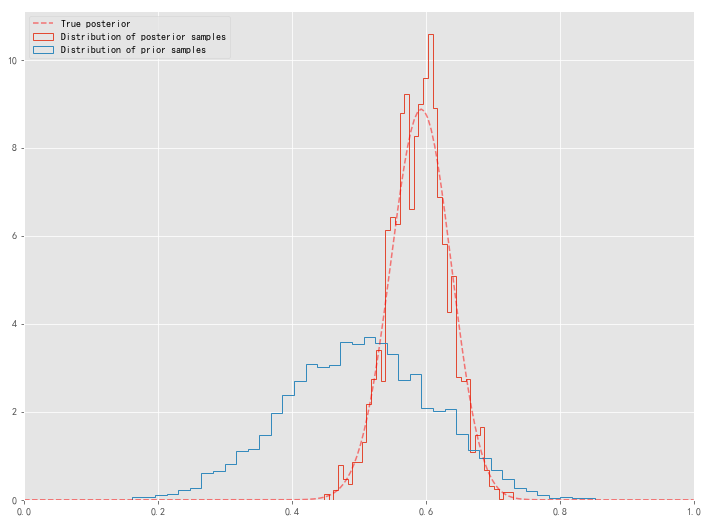

In [12]:
n = 100
h = 61
a = 10
b = 10
sigma = 0.3

lik = st.binom
prior = st.beta(a, b)
post = st.beta(h+a, n-h+b)

def metropolis_hastings(niters):
    def target(theta):
        if theta < 0 or theta > 1:
            return 0
        return lik(n, theta).pmf(h) * prior.pdf(theta)
    
    theta = 0.1
    naccept = 0
    samples = np.zeros(niters+1)
    samples[0] = theta
    for i in range(niters):
        theta_p = st.norm(theta, sigma).rvs()
        alpha = min(1, target(theta_p) / target(theta))
        u = np.random.uniform()
        if u < alpha:
            naccept += 1
            theta = theta_p
        samples[i+1] = theta
    print("Efficiency = ", naccept/niters)
    return samples

niters = 10000
thetas = np.linspace(0, 1, 200)
samples = metropolis_hastings(niters)
nmcmc = len(samples)//2

plt.figure(figsize=(12, 9))
plt.hist(samples[nmcmc:], 40, histtype='step', normed=True, linewidth=1, label='Distribution of posterior samples');
plt.hist(prior.rvs(nmcmc), 40, histtype='step', normed=True, linewidth=1, label='Distribution of prior samples');
plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([0,1]);
plt.legend(loc='best')

这里补充一个二元变量的概率分布用 Metropolis-Hastings 采样的例子。假设我们有二元变量 (a, b) 服从二维高斯分布，即：
$$p(a, b) = \mathcal N\left(\left[\begin{array}{c} a \\ b \end{array}\right]; \left[\begin{array}{c}\mu_a \\ \mu_b\end{array}\right], \left[\begin{array}{cc}\sigma_a & cov(a, b) \\ cov(a, b) & \sigma_b\end{array}\right]\right) = \mathcal N\left(\left[\begin{array}{c}a \\ b\end{array}\right]; \left[\begin{array}{c}0 \\ 0\end{array}\right], \left[\begin{array}{cc}1 & 0.5 \\ 0.5 & 1\end{array}\right]\right).$$

我们怎么用 M-H 采样来采样这个高斯分布的独立样本呢？依样画葫芦，我们需要构造一个对称的 $q$，例如这里我用了

$$q(a^\prime,b^\prime|a, b) = \mathcal N\left(\left[\begin{array}{c}a^\prime \\ b^\prime\end{array}\right]; \left[\begin{array}{c}a \\ b\end{array}\right], \left[\begin{array}{cc}1 & 0 \\ 0 & 1\end{array}\right]\right)$$

这样，$\alpha = min\left \{\frac{p(a^\prime, b^\prime)}{p(a, b)}, 1 \right \}$ 可以很容易计算出来。

下面代码实现了二维的采样，可以发现采样趋于平稳后，是很符合真实的分布的。

0.5245


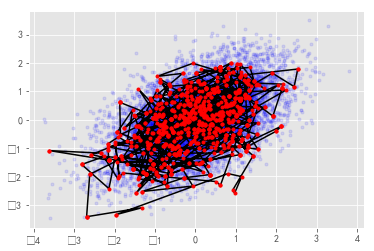

In [14]:
def sample_from_q(x0, x1):
    rv = st.multivariate_normal([x0, x1], [[1, 0], [0, 1]])
    x0_p, x1_p = rv.rvs()
    return x0_p, x1_p

def target(x0, x1):
    x = np.array([x0, x1])
    e = -0.5 * (x - mu) @ np.linalg.inv(joint_cov) @ (x - mu)
    return np.exp(e)

def metropolis_hastings(niters):
    x0, x1 = 3, 3
    samples = [(x0, x1)]
    accept_count = 0
    for _ in range(niters):
        x0_p, x1_p = sample_from_q(x0, x1)
        alpha = min(1, target(x0_p, x1_p) / target(x0, x1))
        if np.random.uniform(0, 1) < alpha:
            x0, x1 = x0_p, x1_p
            accept_count += 1
        samples.append((x0, x1))
    return samples, accept_count / niters


D = 2
N = 10000

# set up the means
a_mu = 0
b_mu = 0
mu = np.array([a_mu, b_mu])

a_sigma = 1
b_sigma = 1
a_b_cov = 0.5

joint_cov = np.vstack(((a_sigma, a_b_cov), (a_b_cov, b_sigma)))
joint_mu = np.vstack((a_mu, b_mu))

L = np.linalg.cholesky(joint_cov)
samples_from_true_distribution =  L @ np.random.randn(D, N) + joint_mu

samples, accept_rate = metropolis_hastings(2000)
print(accept_rate)
xs = [it[0] for it in samples[1000:]]
ys = [it[1] for it in samples[1000:]]

plt.plot(*samples_from_true_distribution, '.', color='blue', alpha=0.1)
plt.plot(xs, ys, 'k')
plt.plot(xs, ys, '.r')

## 抛硬币2

为了加深印象，再来一个抛硬币的例子。假设这次我们有两个不太均匀的硬币，硬币1抛了 n1 次后有 z1 次正面朝上，硬币2抛了 n2 次后有 z2 次正面朝上，如何在给定这组观测数据的情况下，估计两枚硬币正面朝上的概率，即 $p(\theta_1, \theta_2 | x1, x2)$ ? 

其实这个问题本身很简单，因为这两个硬币是独立的，联合分布就等于各自的分布相乘。这里主要是为了说明二元变量怎么应用采样方法。

### 解法 1. Analytic solution
和一个硬币一样，我们同样假设每个硬币正面朝上的概率满足 likelihood 的共轭先验 $beta(a, b)$，这时后验分布的形式与先验一样，可以直接求解，代码入下：

In [65]:
def binom(theta, z, N):
    """Binomial likelihood with N trials and z successes."""
    return st.binom(N, theta).pmf(z)

def binom2(theta1, theta2, z1, z2, N1, N2):
    """Binomial likelihood with N trials and z successes."""
    return binom(theta1, z1, N1) * binom(theta2, z2, N2)

def make_thetas(xmin, xmax, n):
    xs = np.linspace(xmin, xmax, n)
    widths =(xs[1:] - xs[:-1])/2.0
    thetas = xs[:-1]+ widths
    return thetas

def make_plots(X, Y, prior, likelihood, posterior, projection=None):
    fig, ax = plt.subplots(1,3, subplot_kw=dict(projection=projection, aspect='equal'), figsize=(12,3))
    if projection == '3d':
        ax[0].plot_surface(X, Y, prior, alpha=0.3, cmap=plt.cm.jet)
        ax[1].plot_surface(X, Y, likelihood, alpha=0.3, cmap=plt.cm.jet)
        ax[2].plot_surface(X, Y, posterior, alpha=0.3, cmap=plt.cm.jet)
    else:
        ax[0].contour(X, Y, prior)
        ax[1].contour(X, Y, likelihood)
        ax[2].contour(X, Y, posterior)
    ax[0].set_title('Prior')
    ax[1].set_title('Likelihood')
    ax[2].set_title('Posteior')
    plt.tight_layout()

thetas1 = make_thetas(0, 1, 101)
thetas2 = make_thetas(0, 1, 101)
X, Y = np.meshgrid(thetas1, thetas2)

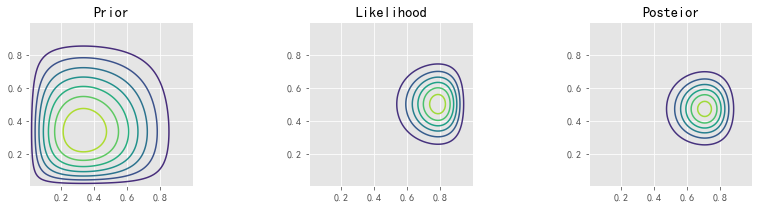

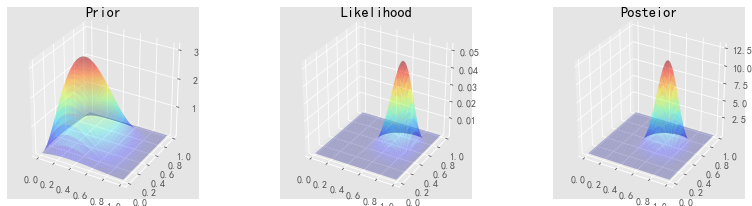

In [66]:
a = 2
b = 3

z1 = 11
N1 = 14
z2 = 7
N2 = 14

prior = st.beta(a, b).pdf(X) * st.beta(a, b).pdf(Y)
likelihood = binom2(X, Y, z1, z2, N1, N2)
posterior = st.beta(a + z1, b + N1 - z1).pdf(X) * st.beta(a + z2, b + N2 - z2).pdf(Y)
make_plots(X, Y, prior, likelihood, posterior)
make_plots(X, Y, prior, likelihood, posterior, projection='3d')

###  解法 2. Numerical integration
同样用 grid approximation 的方法，我们假设 $\theta_1$ 和 $\theta_2$ 各自服从一个高斯分布作为先验分布。看看用观测样本修正之后，参数的后验分布会长什么样。

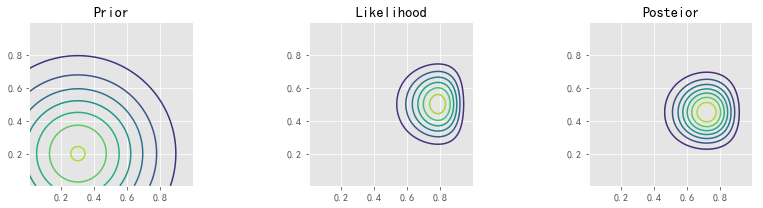

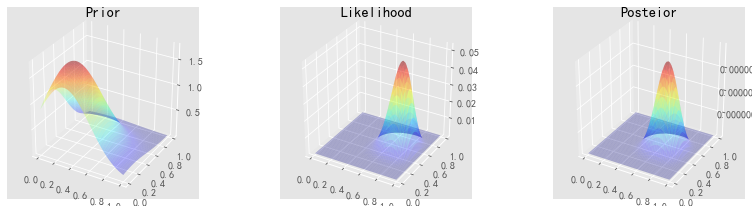

In [72]:
def gaussian_prior(x, y):
    return st.norm(0.3, 0.3).pdf(x) * st.norm(0.2, 0.3).pdf(y)

ni_prior = gaussian_prior(X, Y)
ni_likeli = binom2(X, Y, z1, z2, N1, N2)
ni_posterior = ni_likeli * ni_prior
ni_posterior /= posterior.sum()

make_plots(X, Y, ni_prior, ni_likeli, ni_posterior)
make_plots(X, Y, ni_prior, ni_likeli, ni_posterior, projection='3d')

### 解法 3-1. M-H 采样
在 M-H 采样中，我们首先想到的就是构造一个对称的 proposal 分布，这里我们用：

$$q(\theta_1^\prime,\theta_2^\prime|\theta_1, \theta_2) = \mathcal N\left(\left[\begin{array}{c}\theta_1^\prime \\ \theta_2^\prime\end{array}\right]; \left[\begin{array}{c}\theta_1 \\ \theta_2\end{array}\right], \left[\begin{array}{cc}1 & 0 \\ 0 & 1\end{array}\right]\right)$$

于是，在算 $\alpha$ 的时候，$q$ 可以约掉，后验概率中的积分部分可以抵消掉，得到：
$$\alpha = min \left \{ \frac{p(\theta_1^\prime, \theta_2^\prime | x, y)}{p(\theta_1, \theta_2 | x, y)}, 1 \right \} = min \left \{ \frac{prior(\theta_1^\prime, \theta_2^\prime)likelihood(x, y|\theta_1^\prime, \theta_2^\prime)}{prior(\theta_1, \theta_2)likelihood(x, y|\theta_1, \theta_2)}, 1 \right \}$$

通过代码看看采样之后长什么样：

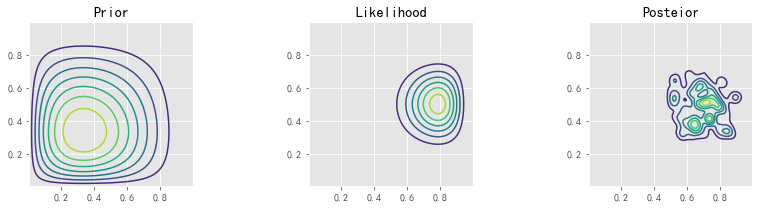

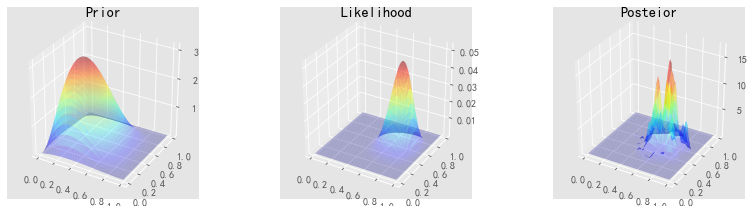

In [76]:
from functools import partial
a = 2
b = 3

z1 = 11
N1 = 14
z2 = 7
N2 = 14

prior = lambda theta1, theta2: st.beta(a, b).pdf(theta1) * st.beta(a, b).pdf(theta2)
lik = partial(binom2, z1=z1, z2=z2, N1=N1, N2=N2)
target = lambda theta1, theta2: prior(theta1, theta2) * lik(theta1, theta2)

theta = np.array([0.5, 0.5])
niters = 10000
burnin = 500
sigma = np.diag([1, 1])

thetas = np.zeros((niters-burnin, 2), np.float)
for i in range(niters):
    new_theta = st.multivariate_normal(theta, sigma).rvs()
    p = min(target(*new_theta)/target(*theta), 1)
    if np.random.rand() < p:
        theta = new_theta
    if i >= burnin:
        thetas[i-burnin] = theta
        
# 用高斯核来估计这些样本点的概率密度。
kde = st.gaussian_kde(thetas.T)
XY = np.vstack([X.ravel(), Y.ravel()])
posterior_metroplis = kde(XY).reshape(X.shape)
make_plots(X, Y, prior(X, Y), lik(X, Y), posterior_metroplis)
make_plots(X, Y, prior(X, Y), lik(X, Y), posterior_metroplis, projection='3d')

### 解法 3-2. Gibbs 采样
由于在高维的情况下，由于 M-H 方法中还是存在接受率， 算法的效率可能还是不够高，并且当联合分布不太好求，而条件分布很容易获得的时候，Gibbs 采样的优势就体现出来了。

Gibbs 采样的原理是，**假如高维空间中有一个点 $A = (x_1, x_2, ... x_d)$，我们沿着某个维度 $i$ 运动，固定住其它维度，并以条件概率 $p(x_i|x_1, x_2, ... x_d)$ 作为转移概率，那么这个转移是满足细致平稳条件的。** 这个证明可以考虑二维坐标系，自己画画看。

于是，Gibbs 采样的做法是遍历每个维度，固定住其它维度，并通过转移概率采样下一个点，流程如下：

![Gibbs](https://raw.githubusercontent.com/wzpfish/paper-note/master/figures/sampling/gibbs.png)

这个方法也叫坐标轴轮换，遍历完一遍所有维度称为一个 cycle。Gibbs 采样的优点是不需要 propose 一个概率分布 $q$.

缺点是：
1. 需要条件分布可以计算。
2. 需要能容易地从条件概率中采样。
3. 可能很慢，因为只能沿着坐标轴平移，不能走对角线抄近路。

在抛硬币的例子中，由于 $\theta_1$ 和 $\theta_2$ 是独立的，所以条件分布就是它们各自的后验分布。下面代码介绍了抛硬币如果用 Gibbs 采样的结果，对比 M-H，发现在这个例子中，Gibbs 的效果还是漂亮一些的。

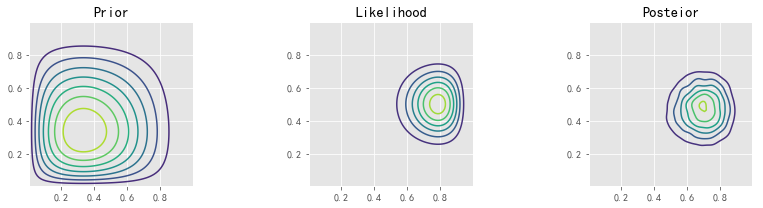

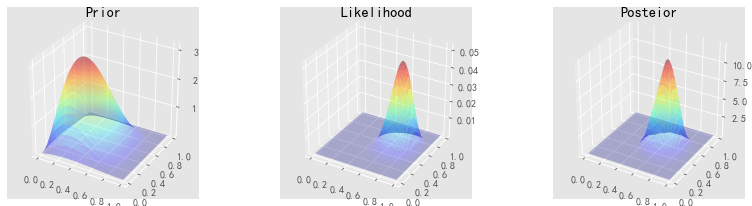

In [78]:
a = 2
b = 3

z1 = 11
N1 = 14
z2 = 7
N2 = 14

prior = lambda theta1, theta2: st.beta(a, b).pdf(theta1) * st.beta(a, b).pdf(theta2)
lik = partial(bern2, z1=z1, z2=z2, N1=N1, N2=N2)
target = lambda theta1, theta2: prior(theta1, theta2) * lik(theta1, theta2)

theta = np.array([0.5, 0.5])
niters = 10000
burnin = 500
sigma = np.diag([1, 1])

thetas = np.zeros((niters-burnin,2), np.float)
for i in range(niters):
    theta = [st.beta(a + z1, b + N1 - z1).rvs(), theta[1]]
    theta = [theta[0], st.beta(a + z2, b + N2 - z2).rvs()]

    if i >= burnin:
        thetas[i-burnin] = theta
        
kde = st.gaussian_kde(thetas.T)
XY = np.vstack([X.ravel(), Y.ravel()])
posterior_gibbs = kde(XY).reshape(X.shape)
make_plots(X, Y, prior(X, Y), lik(X, Y), posterior_gibbs)
make_plots(X, Y, prior(X, Y), lik(X, Y), posterior_gibbs, projection='3d')

## 总结

我们以抛硬币为实例，介绍了如何计算后验概率 $p(\theta|x)$ 或从后验概率中采样独立的样本点。这里再强调一下通常的做法：
1. 为似然函数 $p(x|\theta)$ 找一个共轭先验 $p(\theta)$，使得后验概率有解析解。
2. 用 numerical integration 方法，如 grid approximation，用累加和 ${\sum_{\theta^*}p(X|\theta^*)p(\theta^*)}$ 来近似积分项 ${\int p(X|\theta^*)p(\theta^*)d\theta^*}$。
3. 用一个已知形式的函数去贴近后验分布，比如 VAE 中用到的变分方法。
4. MCMC 方法来对后验分布采样，收集到独立样本点。

本文主要介绍 MCMC 和两种不同的变种，总结一下我觉得的区别：

| 方法 | 优点 | 缺点 | 适用场景 |
| :--- | :--- | :--- | :--- |
| MCMC | 无？ | 1. 需要构造合适的 proposal 概率 <br/> 2. 后验概率要能计算 | 一般不直接用把 | 
| Metropolis-Hastings | 不需要直接计算后验概率，只需要可以计算后验概率的某个比例即可 | 需要构造合适的 proposal 概率 | 多维情况下，联合分布好计算的时候 |
| Gibbs | 只需要计算条件概率 | 采样时是坐标轴轮转，可能收敛比较慢。 | 条件概率很容易算的时候 |

## Reference
* [Duke: Markov Chain Monte Carlo (MCMC)](https://people.duke.edu/~ccc14/sta-663/MCMC.html)
* [Gibbs Sampling in Python](https://nbviewer.jupyter.org/github/jessstringham/notebooks/blob/master/2018-05-09-gibbs-sampling.ipynb)
* [LDA 数学八卦](http://bloglxm.oss-cn-beijing.aliyuncs.com/lda-LDA%E6%95%B0%E5%AD%A6%E5%85%AB%E5%8D%A6.pdf)